In [1]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil

#import kaggle datasets download
from kaggle_datasets import KaggleDatasets


In [2]:
os.mkdir("/kaggle/train")
os.mkdir("/kaggle/test")

os.mkdir("/kaggle/train/blurImage")
os.mkdir("/kaggle/train/sharpImage")

os.mkdir("/kaggle/test/blurImage")
os.mkdir("/kaggle/test/sharpImage")


In [3]:
path = "/kaggle/input/blur-dataset"
listImage = []

for i in os.listdir(path):

    if i=="sharp" or i=="blur_dataset_scaled":

        continue

    for j in os.listdir(path+"/"+i):


        try:

            if j.split(".")[1]!="JPG" and j.split(".")[1]!="jpg" and j.split(".")[1]!="jpeg":

                pass
        except:

            pass

        listImage.append(path+"/"+i+"/"+j)


random.shuffle(listImage)
train_blur = listImage[0:500]
test_blur = listImage[600:]

print(len(train_blur))
print(len(test_blur))


500
100


In [4]:
for i in train_blur:

    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]

    try:

        shutil.copyfile(i, "/kaggle/train/blurImage/"+image_name)

    except:

        pass


In [5]:
len(os.listdir("/kaggle/train/blurImage/"))


500

In [6]:
for i in test_blur:

    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]


    shutil.copyfile(i, "/kaggle/test/blurImage/"+image_name)


In [7]:
len(os.listdir("/kaggle/test/blurImage/"))


100

In [8]:
path = "/kaggle/input/blur-dataset"
listImage = []

for i in os.listdir(path):

    if i!="sharp":

        continue

    for j in os.listdir(path+"/"+i):


        try:

            if j.split(".")[1]!="JPG" and j.split(".")[1]!="jpg" and j.split(".")[1]!="jpeg":

                pass
        except:

            pass

        listImage.append(path+"/"+i+"/"+j)


random.shuffle(listImage)
train_sharp = listImage[0:300]
test_sharp = listImage[300:]
print(len(train_sharp))
print(len(test_sharp))


300
50


In [9]:
for i in train_sharp:

    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]

    try:

        shutil.copyfile(i, "/kaggle/train/sharpImage/"+image_name)


    except:

        pass


In [10]:
len(os.listdir("/kaggle/train/sharpImage/"))


300

In [11]:
for i in test_sharp:

    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]

    try:

        shutil.copyfile(i, "/kaggle/test/sharpImage/"+image_name)

    except:

        pass


In [12]:
len(os.listdir("/kaggle/test/sharpImage/"))


50

In [13]:
IMAGE_SIZE = 600
BATCH_SIZE = 32
path = "/kaggle"

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    path+"/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    path+"/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')


Found 640 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [14]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape


((30, 600, 600, 3), (30, 2))

In [15]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False


9420800/9406464 [==============================] - 0s 0us/step


In [16]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax')
])


In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 19, 19, 1280)      2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 32)        368672    
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,626,722
Trainable params: 368,738
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))


Number of trainable weights = 4


In [20]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))


Epoch 1/5
20/20 [==============================] - 46s 2s/step - loss: 0.5073 - accuracy: 0.8297 - val_loss: 0.2935 - val_accuracy: 0.9333
Epoch 2/5
20/20 [==============================] - 35s 2s/step - loss: 0.1193 - accuracy: 0.9563 - val_loss: 0.2618 - val_accuracy: 0.9333
Epoch 3/5
20/20 [==============================] - 35s 2s/step - loss: 0.0436 - accuracy: 0.9844 - val_loss: 0.2465 - val_accuracy: 0.9333
Epoch 4/5
20/20 [==============================] - 35s 2s/step - loss: 0.0301 - accuracy: 0.9922 - val_loss: 0.2599 - val_accuracy: 0.9333
Epoch 5/5
20/20 [==============================] - 35s 2s/step - loss: 0.0163 - accuracy: 0.9984 - val_loss: 0.2798 - val_accuracy: 0.9333


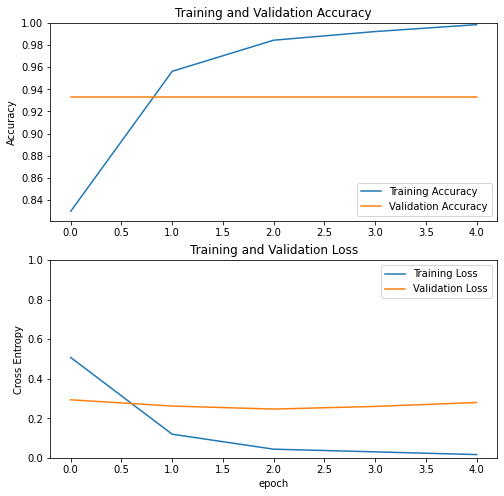

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
train_generator[0][0].shape


(32, 600, 600, 3)

In [24]:
sn = model.predict(train_generator[11][0])


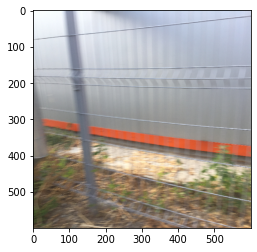

Label : blur


In [25]:
count = 5
plt.imshow(train_generator[11][0][count])
plt.show()

if sn[count][0]> sn[count][1]:

    print("Label : blur")

else:

    print("Label : sharp")


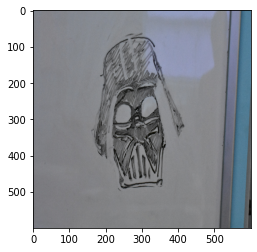

Label : sharp


In [26]:
count = 0
plt.imshow(train_generator[11][0][count])
plt.show()

if sn[count][0]> sn[count][1]:

    print("Label : blur")

else:

    print("Label : sharp")


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

vision_images_path = '/kaggle/input/vision-blur-images/'
vision_images = os.listdir(vision_images_path)



def get_data(path,images):
    rgb_images=[]
    for img in images:
        image_rgb = cv2.cvtColor(cv2.imread(path+img), cv2.COLOR_BGR2RGB)
        image_rgb = cv2.resize(image_rgb, dsize=(600, 600))
        rgb_images.append(image_rgb)
    return rgb_images

vision_features = get_data(vision_images_path, vision_images)
vision_features[0].shape


(600, 600, 3)

In [33]:
np.array(vision_features).shape


(10, 600, 600, 3)

In [34]:
sn = model.predict(np.array(vision_features))
sn


array([[0.11864727, 0.8813528 ],
       [0.6018613 , 0.3981387 ],
       [0.793455  , 0.20654498],
       [0.5726914 , 0.42730865],
       [0.41507608, 0.5849239 ],
       [0.61111116, 0.38888884],
       [0.34045848, 0.6595415 ],
       [0.31621242, 0.6837876 ],
       [0.9108852 , 0.08911477],
       [0.5429371 , 0.45706296]], dtype=float32)

In [35]:
model.save("blurr_model.h5")


In [36]:
blurs = sharps = 0
for i in range(sn.shape[0]):
    if sn[i][0]> sn[i][1]:
        blurs += 1
    else:
        sharps += 1

print(f"sharps: {sharps}, blurs: {blurs}")


sharps: 4, blurs: 6
